In [1]:
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket='solarflares' # customize to your bucket

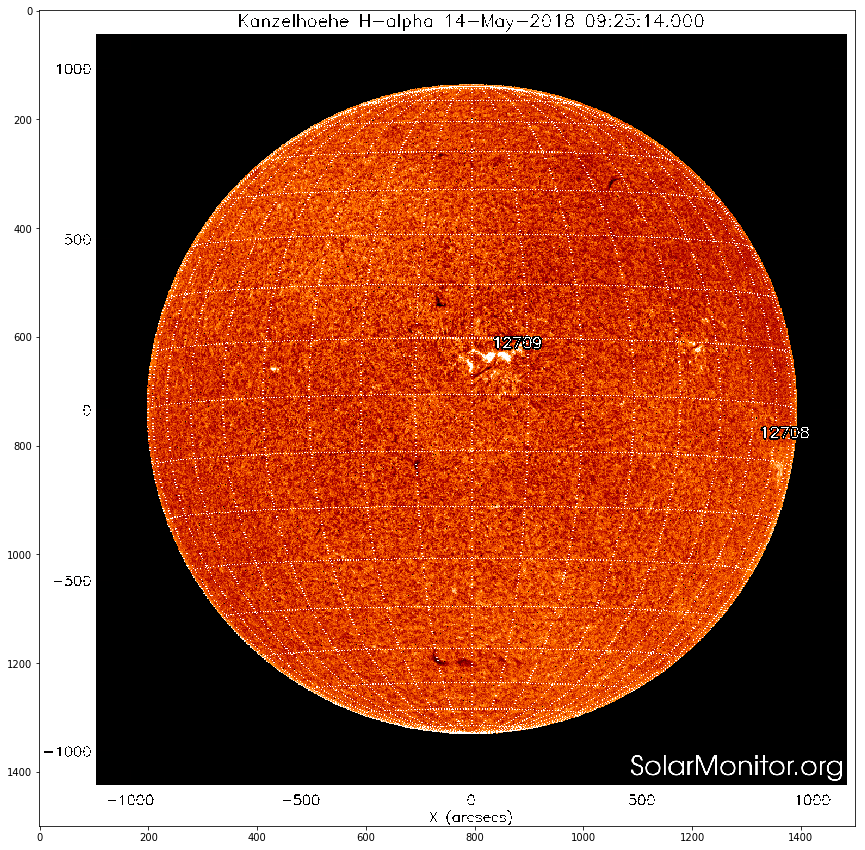

In [3]:
import matplotlib.image as mpimg
import wget
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os 
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


s3_key = "sunimages/img"
s3_t = 's3://{}/{}/'.format(bucket, s3_key)

download('https://solarmonitor.org/data/2018/05/14/pngs/bbso/bbso_halph_fd_20180514_092514.png')
upload_to_s3(s3_key, 'bbso_halph_fd_20180514_092514.png')
img = mpimg.imread('bbso_halph_fd_20180514_092514.png')
plt.figure(figsize=(15,15))
imgplot=plt.imshow(img)

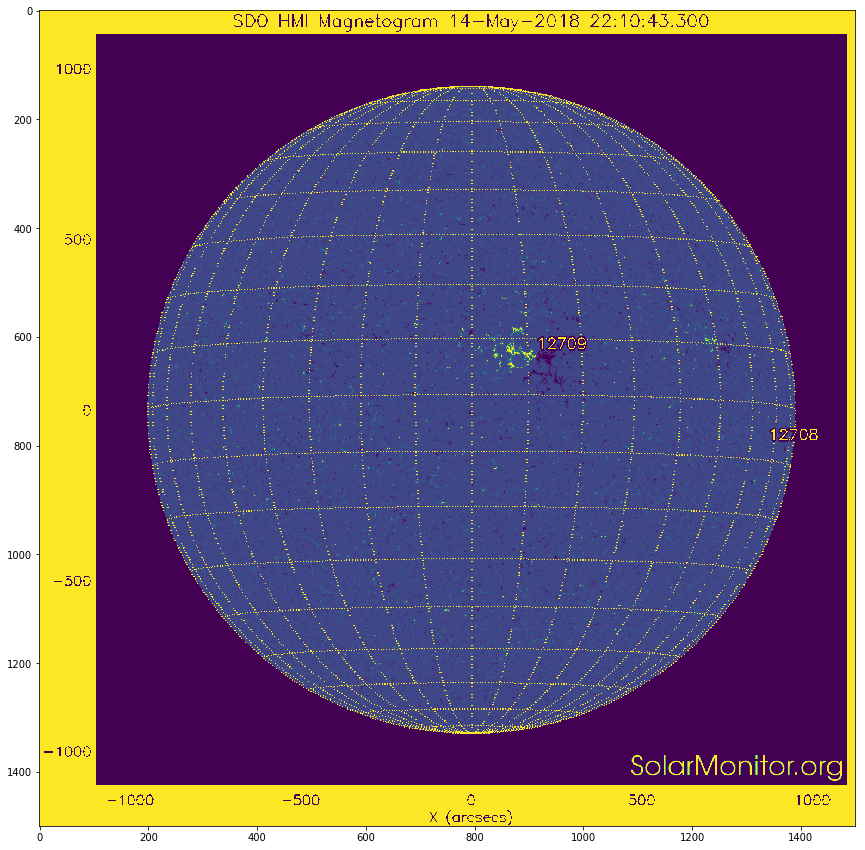

In [4]:
download('https://solarmonitor.org/data/2018/05/14/pngs/shmi/shmi_maglc_fd_20180514_221043.png')
upload_to_s3(s3_key, 'shmi_maglc_fd_20180514_221043.png')
img = mpimg.imread('shmi_maglc_fd_20180514_221043.png')
plt.figure(figsize=(15,15))
imgplot=plt.imshow(img)

In [7]:
from datetime import timedelta
import numpy as np
import pandas as pd
import datetime
import sunpy
from sunpy.time import TimeRange
from sunpy.instr import goes

In [8]:
time_range = TimeRange('2010/01/01 00:10', '2018/12/31 00:20')
#time_range = TimeRange(t_start,t_end)
goes_events = goes.get_goes_event_list(time_range,'C1')
goes_events = pd.DataFrame(goes_events)
goes_events['noaa_active_region'] = goes_events['noaa_active_region'].replace(0,np.nan)
goes_events.dropna(inplace=True)    
goes_events.drop(['goes_location','event_date','end_time','peak_time'], axis=1, inplace=True)
goes_events.start_time = goes_events.start_time.astype('datetime64[ns]')

In [9]:
goes_events.sort_values(by = 'start_time').tail(10)

,goes_class,noaa_active_region,start_time
8640,C8.1,12699.0,2018-02-07 13:31:00
8641,C1.7,12699.0,2018-02-07 14:35:00
8642,C4.6,12699.0,2018-02-10 13:02:00
8643,C1.5,12699.0,2018-02-12 00:15:00
8644,C1.9,12700.0,2018-03-02 10:56:00
8645,C4.6,12703.0,2018-03-30 07:57:00
8646,C2.0,12712.0,2018-05-23 18:03:00
8647,C2.7,12712.0,2018-05-28 17:04:00
8648,C1.0,12712.0,2018-06-06 10:44:00
8649,C2.1,12715.0,2018-06-21 01:09:00


In [10]:
s3_key1 = "data"
s3_t1 = 's3://{}/{}/'.format(bucket, s3_key1)
#download mapper NOAA
num_mapper = pd.read_csv('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt',sep=' ')
#num_mapper.to_csv(os.path.join(s3_t1,'all_harps_with_noaa_ars.txt'), sep=' ')
download('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt')
upload_to_s3(s3_key1,'all_harps_with_noaa_ars.txt')
num_mapper.to_csv('all_harps_with_noaa_ars.txt', sep=' ')

In [11]:
num_mapper.tail()

,HARPNUM,NOAA_ARS
1323,7326,12730
1324,7327,12731
1325,7331,12732
1326,7334,12733
1327,7348,12734


In [12]:
def convert_noaa_to_harpnum(noaa_ar):
    """
    Converts from a NOAA Active Region to a HARPNUM
    Returns harpnum if present, else None if there are no matching harpnums
    
    Args:
    """
    idx = num_mapper[num_mapper['NOAA_ARS'].str.contains(str(int(noaa_ar)))]
    return None if idx.empty else int(idx.HARPNUM.values[0])
goes_events['harp_number'] = goes_events['noaa_active_region'].apply(convert_noaa_to_harpnum)
goes_events.dropna(inplace=True)

In [13]:
#Goes class flares better convert to flux value. It could be done with method flareclass_to_flux from goes
goes_events['flux'] =  goes_events['goes_class'].apply(lambda x: 1e06*goes.flareclass_to_flux(x).value)
goes_events.head()

,goes_class,noaa_active_region,start_time,harp_number,flux
96,C2.2,11067.0,2010-04-30 19:28:00,1.0,2.2
97,C5.7,11067.0,2010-05-01 01:34:00,1.0,5.7
98,C3.6,11069.0,2010-05-04 16:15:00,8.0,3.6
99,C2.3,11069.0,2010-05-05 07:09:00,8.0,2.3
100,C8.8,11069.0,2010-05-05 11:37:00,8.0,8.8


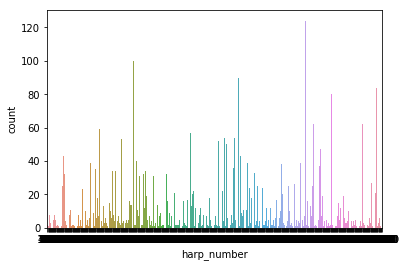

In [24]:
import seaborn as sns
sns.countplot(x='harp_number', data = goes_events)

In [15]:
from io import StringIO, BytesIO

In [33]:
import boto3
from io import StringIO
#here list of keywords we want to download. Keywords computed for harp regions. 
#Here we walk through the all harp regions, download features and save them to disk (it is very time consuming)
import drms
c = drms.Client()
list_keywords = ['T_REC,CRVAL1,CRLN_OBS,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH']
harp_list = pd.unique(goes_events.harp_number)
N=len(harp_list)
k=0
s3_key2 = "data/keys_regions"
s3_t2 = 's3://{}/{}/'.format(bucket, s3_key2)
for harp in harp_list:
    str_query = f'hmi.sharp_cea_720s[{str(int(harp))}]'

    if os.path.isfile(os.path.join(s3_t2+'/keys_regions',str_query+'.csv')):
        #print(f'Harp number {harp} already exist\n')
        k=k+1
    else:
        '''def upload_too_s3(channel,file):
            s3 = boto3.resource('s3')
            #data = open(file, "w")
            key = channel + '/' + file
            s3.Bucket(bucket).put_object(Key=key, Body=c.query(str_query,key=list_keywords))'''
  

        DESTINATION = 'solarflares'

        def write_dataframe_to_csv_on_s3(dataframe, filename):
            """ Write a dataframe to a CSV on S3 """
            print("Writing {} records to {}".format(len(dataframe), filename))
            # Create buffer
            csv_buffer = StringIO()
            # Write dataframe to buffer
            dataframe.to_csv(csv_buffer, sep=",", index=False)
            # Create S3 object
            s3_resource = boto3.resource("s3")
            # Write buffer to S3 object
            s3_resource.Object(DESTINATION, filename).put(Body=csv_buffer.getvalue())
        #keys = StringIO()
        #k.to_csv(csv_buffer)
        #s3_resource.Object(bucket_name, 'df.csv').put(Body=csv_buffer.getvalue())
        print(f'load region with Harp number {harp}')
        keys = c.query(str_query, key=list_keywords)
        write_dataframe_to_csv_on_s3(keys, 'data/keys_regions/'+str_query+'.csv')
        #keys.to_csv(upload_too_s3(s3_key2,str_query+'.csv'))

load region with Harp number 1.0
Writing 1247 records to data/keys_regions/hmi.sharp_cea_720s[1].csv
load region with Harp number 8.0
Writing 728 records to data/keys_regions/hmi.sharp_cea_720s[8].csv
load region with Harp number 54.0
Writing 439 records to data/keys_regions/hmi.sharp_cea_720s[54].csv
load region with Harp number 51.0
Writing 424 records to data/keys_regions/hmi.sharp_cea_720s[51].csv
load region with Harp number 49.0
Writing 589 records to data/keys_regions/hmi.sharp_cea_720s[49].csv
load region with Harp number 86.0
Writing 1479 records to data/keys_regions/hmi.sharp_cea_720s[86].csv
load region with Harp number 92.0
Writing 1553 records to data/keys_regions/hmi.sharp_cea_720s[92].csv
load region with Harp number 104.0
Writing 1604 records to data/keys_regions/hmi.sharp_cea_720s[104].csv
load region with Harp number 115.0
Writing 1652 records to data/keys_regions/hmi.sharp_cea_720s[115].csv
load region with Harp number 156.0
Writing 772 records to data/keys_regions/h

In [59]:
import s3fs
from smart_open import open
def plot_harp_features_flares(harp, goes_events = goes_events,feature_key = 'R_VALUE'):
    str_query = f'hmi.sharp_cea_720s[{str(int(harp))}]'
    df = pd.read_csv(open('s3://solarflares/data/keys_regions/'+str_query+'.csv'))
    df["T_REC"]  = drms.to_datetime(df.T_REC)
    df.set_index('T_REC', inplace=True)
    first_date = df.index.get_values()[0]

    is_visible =  abs(df['CRVAL1']-df['CRLN_OBS'])<60
    df = df[is_visible]

    flux = goes_events[goes_events['harp_number']==harp][['start_time','flux']].set_index('start_time')
    #plt.figure(figsize = (10,14))
    fig, ax1 = plt.subplots(figsize=(15,5))
    #ax1.figure(figsize = (10,14))
    first_date = flux.index.get_values()[0]
    first_date = df.index.get_values()[0]
    #t2 = flux.index.get_values()[0]
    #first_data = min(t1,t2)
    dates_to_show = pd.date_range(pd.Timestamp(first_date).strftime('%m/%d/%Y'), periods=14, freq='d')
    labels = dates_to_show.strftime('%b %d')
    color = 'tab:green'
    ax1.plot(df.index, df[feature_key], color=color)
    ax2 = ax1.twinx()
    ax2.bar(flux.index, flux.flux, width=0.05, facecolor='indianred')
    plt.setp(ax1, xticks=dates_to_show, xticklabels=labels);
    #ax2.set_ylim(0,10)

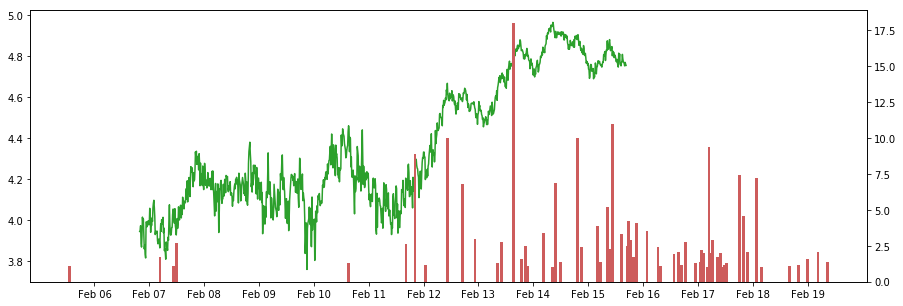

In [60]:
harp = 6327
plot_harp_features_flares(harp, feature_key = 'R_VALUE')

In [63]:
#Features from CSV
'''Now we need to generate features from time series evolutions. It is believed that active region "prepared for giving a flare". 
So we decided to take complexity features at the considered moment add aggregates from the past'''
'''1. Features at the time moment, not all moments each 2 hours
2. Mean and range (max-min) for features at the last 2 hours
3. Mean and range (max-min) at the last 6 hours
4. Mean and range (max-min) at the last 12 hours
5. Mean and range (max-min) at the last 24 hours
6. Mean and range (max-min) at the last 48 hours'''
def extract_features_from_csv(harp, time_stamp = 2, delay_hours = [2,6,12,24,48], long=70):
    """
    process downloaded csv files with time series features and create features from them
    harp: harp number 
    time_stamp: frequence 
    delay_hour:
    return: data_frame with features
    """
    str_query = f'hmi.sharp_cea_720s[{str(int(harp))}]'
    df = pd.read_csv(open('s3://solarflares/data/keys_regions/'+str_query+'.csv'))
    df['T_REC']  = drms.to_datetime(df.T_REC)
    df.set_index('T_REC', inplace=True)
    is_visible =  abs(df['CRVAL1']-df['CRLN_OBS'])<long
    df = df[is_visible].drop(['CRVAL1','CRLN_OBS'], axis=1)
    first_date = df.index.get_values()[0]
    last_date = df.index.get_values()[-1]
    first_date = first_date+np.timedelta64(1, 'D')
    #round to closet whole hour
    first_date = pd.to_datetime(first_date).replace(microsecond=0,second=0,minute=0)+timedelta(hours=1)
    
    t_range = pd.date_range(first_date, last_date, freq=str(time_stamp)+'H')
    df_orig = df.loc[t_range]
    df_list = []
    df_list.append(df_orig)
    for delay in delay_hours:
        columns_=[col+'_mean_'+str(delay) for col in df_orig.columns]
        df_delay = df.rolling(str(delay)+'h').mean()
        df_delay.columns = columns_
        df_delay = df_delay.loc[t_range]
        df_list.append(df_delay)  
        columns_=[col+'_range_'+str(delay) for col in df_orig.columns]
        df_delay = df.rolling(str(delay)+'h').max() - df.rolling(str(delay)+'h').min()
        df_delay.columns = columns_
        df_delay = df_delay.loc[t_range]
        df_list.append(df_delay)
    full_df = pd.concat(df_list, axis=1) 
    full_df.dropna(inplace=True)
    full_df['HARP']=harp
    return full_df

In [64]:
harp = harp_list[4]
full_df = extract_features_from_csv(harp)
full_df.head()

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,MEANGBZ_range_48,MEANJZD_range_48,TOTUSJZ_range_48,SAVNCPP_range_48,TOTPOT_range_48,MEANSHR_range_48,AREA_ACR_range_48,R_VALUE_range_48,ABSNJZH_range_48,HARP
2010-06-10 04:00:00,2.235606e+21,141.044,-0.002669,2297.217,1.901,144.397,54.265,-0.007326,29.477,141.583,...,144.000,12.197661,3.008553e+12,1.718105e+12,1.039682e+22,52.243,79.112152,2.845,12.092,49.0
2010-06-10 06:00:00,2.423397e+21,133.750,-0.002078,1929.119,1.861,145.473,49.236,-0.006469,27.939,131.636,...,82.062,4.060860,2.957626e+12,1.698659e+12,1.028199e+22,27.286,77.160964,2.845,12.076,49.0
2010-06-10 08:00:00,2.497526e+21,127.085,-0.001155,1903.451,1.742,157.283,46.487,-0.003606,27.345,125.699,...,63.137,2.968393,2.955098e+12,1.688594e+12,9.902366e+21,20.872,74.821623,2.845,12.076,49.0
2010-06-10 10:00:00,2.196429e+21,135.547,0.000110,1971.593,2.134,140.319,48.598,0.000301,26.493,134.640,...,53.445,1.691768,2.247815e+12,1.688594e+12,7.593688e+21,14.536,52.541769,2.845,12.076,49.0
2010-06-10 12:00:00,2.175385e+21,134.130,0.000092,1736.382,1.776,128.176,46.337,0.000273,26.227,133.218,...,53.445,1.691768,2.247815e+12,1.688594e+12,7.570174e+21,14.834,48.700150,2.845,12.076,49.0


In [65]:
#Define target
'''At each active region (harp) at each moment targer will be the number of events where flux exceed M1.0 level (or 10 in flux value) in any time in the next 24 hours and 0 when there is not such events. 
Actually I will predict only the fact of solar flares, but maybe in future this information will be usefull, especially on error analysis stage'''

def compute_target(full_df, goes_events=goes_events, horizont = 24, level = 10):
    harp = full_df['HARP'][0]
    big_events = goes_events[(goes_events['harp_number']==harp) &(goes_events.flux>level)]
    target = pd.Series(full_df.index.map(lambda x: np.sum((x>big_events.start_time - np.timedelta64(horizont,'h'))
           & (x<big_events.start_time))))
    full_df['target'] = target.values
    return full_df 
full_df=compute_target(full_df)

In [66]:
#Feature from goes history
def compute_prev_flux(full_df, goes_events=goes_events):
    harp = full_df['HARP'][0]

    goes_harp = goes_events[(goes_events['harp_number']==harp)]
    prev_flux  = pd.Series(full_df.index.map(lambda x: goes_harp.loc[goes_harp.start_time<x].flux.sum()))
    full_df['prev_flux'] = prev_flux.values
    return full_df
full_df=compute_prev_flux(full_df)

In [67]:
full_df.head()

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,TOTUSJZ_range_48,SAVNCPP_range_48,TOTPOT_range_48,MEANSHR_range_48,AREA_ACR_range_48,R_VALUE_range_48,ABSNJZH_range_48,HARP,target,prev_flux
2010-06-10 04:00:00,2.235606e+21,141.044,-0.002669,2297.217,1.901,144.397,54.265,-0.007326,29.477,141.583,...,3.008553e+12,1.718105e+12,1.039682e+22,52.243,79.112152,2.845,12.092,49.0,0,0.0
2010-06-10 06:00:00,2.423397e+21,133.750,-0.002078,1929.119,1.861,145.473,49.236,-0.006469,27.939,131.636,...,2.957626e+12,1.698659e+12,1.028199e+22,27.286,77.160964,2.845,12.076,49.0,0,0.0
2010-06-10 08:00:00,2.497526e+21,127.085,-0.001155,1903.451,1.742,157.283,46.487,-0.003606,27.345,125.699,...,2.955098e+12,1.688594e+12,9.902366e+21,20.872,74.821623,2.845,12.076,49.0,0,0.0
2010-06-10 10:00:00,2.196429e+21,135.547,0.000110,1971.593,2.134,140.319,48.598,0.000301,26.493,134.640,...,2.247815e+12,1.688594e+12,7.593688e+21,14.536,52.541769,2.845,12.076,49.0,0,0.0
2010-06-10 12:00:00,2.175385e+21,134.130,0.000092,1736.382,1.776,128.176,46.337,0.000273,26.227,133.218,...,2.247815e+12,1.688594e+12,7.570174e+21,14.834,48.700150,2.845,12.076,49.0,0,0.0


In [68]:
from tqdm import tqdm

In [82]:
bucket='solarflares'
key='pkl/'+'solar_train.pkl'
df_list=[]
lp=pd.DataFrame()
for harp in tqdm(harp_list):
    df_ = extract_features_from_csv(harp)
    if df_.shape[0]==0:
        continue
    df_ = compute_target(df_, goes_events=goes_events)
    df_ = compute_prev_flux(df_)
    df_['Time'] = df_.index
    df_list.append(df_)
train_df = pd.concat(df_list, ignore_index=True).sort_values("Time")
pickle_buffer = BytesIO()
s3_resource = boto3.resource('s3')
train_df.to_pickle(pickle_buffer)
s3_resource.Object(bucket, key).put(Body=pickle_buffer.getvalue())
#train_df.to_pickle(os.path.join(DATA_PATH, 'solar_train.pkl'))

100%|██████████| 628/628 [05:35<00:00,  2.03it/s]


{'ResponseMetadata': {'RequestId': '0FDE0DE9BCB70FD7',
  'HostId': 'IBIxSS43ZxYxQ5X3XW0P8HcXwW4bKCWKMcnKstRQW3YR0zSz6aeij2EtgyAsKOikfKE90MA5Z4I=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'IBIxSS43ZxYxQ5X3XW0P8HcXwW4bKCWKMcnKstRQW3YR0zSz6aeij2EtgyAsKOikfKE90MA5Z4I=',
   'x-amz-request-id': '0FDE0DE9BCB70FD7',
   'date': 'Sat, 11 May 2019 23:31:34 GMT',
   'etag': '"7143642058a4a8517b7385f16b967a50"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"7143642058a4a8517b7385f16b967a50"'}

In [83]:
#Target distribution
'''Strong solar flares is rare events. Let's see to the target distribution. We have 4 values of target'''
train_df.target.value_counts()

0     57738
1      2042
2       547
3       221
4        86
5        71
6        30
7        13
8         8
9         7
10        2
11        1
Name: target, dtype: int64

In [84]:
train_df['bin_target'] = train_df.target.map(lambda x: 0 if x==0 else 1)
train_df['bin_target'].value_counts()

0    57738
1     3028
Name: bin_target, dtype: int64

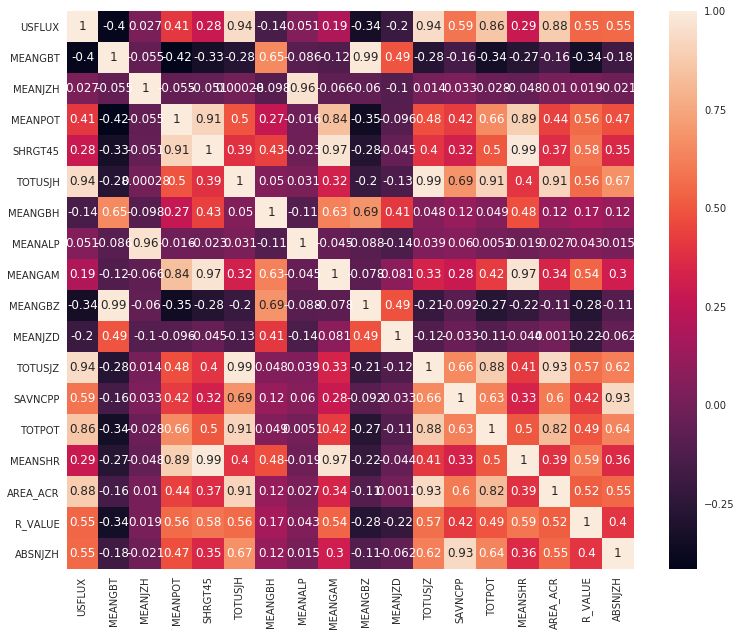

In [85]:
'''Let's see how the main features (without aggregates) depends with each other and with the target'''
key_cols = str.split('USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH', sep=',')
sns.set(rc={'figure.figsize':(12.7,10.27)})
sns.heatmap(train_df[key_cols].corr(), annot=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


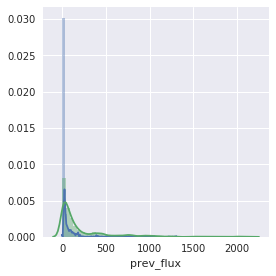

In [93]:
g = sns.FacetGrid(train_df, hue="bin_target",size=4)
g.map(sns.distplot, 'prev_flux')

In [94]:
#Data preprocessing. Metric selection and model selection
'''For cross_validation we will use time series split, in other cases we will get data leakage, through 24 hours we will definitely know about flare
As a model, we start with logistic regression as a baseline, then try random forest'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [95]:
#create Year feature
train_df['Year'] = train_df.Time.dt.year

In [96]:
train_part = train_df.loc[~train_df['Year'].isin([2017,2018])]
test_part = train_df.loc[train_df['Year'].isin([2017,2018])]

In [97]:
train_part.bin_target.value_counts()

0    55533
1     2919
Name: bin_target, dtype: int64

In [98]:
test_part.bin_target.value_counts()

0    2205
1     109
Name: bin_target, dtype: int64

In [99]:
#So we have 2907 positive events in train set and 109 in test. Try to fit baseline model only with key features without aggregates.
tcv = TimeSeriesSplit(n_splits=10)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(class_weight='balanced', random_state=17))])
score = cross_val_score(logit_pipe, train_part[key_cols], train_part['bin_target'], cv=tcv, scoring = 'roc_auc')
print('Validation score:', score)
logit_pipe.fit(train_part[key_cols], train_part['bin_target'])

Validation score: [0.83811197 0.87744361 0.91214578 0.88775583 0.90635559 0.85281733
 0.88134772 0.92024042 0.94550114 0.97176689]


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [100]:
#Actually not so bad, let's see at the confusion matrix at the train and test part.

In [101]:
y_pred = logit_pipe.predict_proba(train_part[key_cols])
class_names = ['No Flare', 'Flare']
pd.DataFrame(confusion_matrix(train_part['bin_target'],y_pred[:,1]>0.5), index=class_names, columns=class_names)

,No Flare,Flare
No Flare,46671,8862
Flare,432,2487


In [102]:
y_pred = logit_pipe.predict_proba(test_part[key_cols])
class_names = ['No Flare', 'Flare']
pd.DataFrame(confusion_matrix(test_part['bin_target'],y_pred[:,1]>0.5), index=class_names, columns=class_names)

,No Flare,Flare
No Flare,1892,313
Flare,10,99


In [106]:
#So we missed 11 flares at the test set, and 432 in train set. Let's try Random Forest.

In [104]:
%%time
rf = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight='balanced')
score = cross_val_score(rf, train_part[key_cols], train_part['bin_target'], cv=tcv, scoring = 'roc_auc')
print('Validation score:', score)

Validation score: [0.87104479 0.85416844 0.92363561 0.87315558 0.92748557 0.82182757
 0.90410142 0.94510202 0.93116271 0.94686911]
CPU times: user 32.4 s, sys: 0 ns, total: 32.4 s
Wall time: 32.4 s


In [105]:
%%time
rf = RandomForestClassifier(n_estimators = 500,  max_depth=3, class_weight='balanced')
rf.fit(train_part[key_cols], train_part['bin_target'])

CPU times: user 32.6 s, sys: 0 ns, total: 32.6 s
Wall time: 32.5 s


In [107]:
rf_pred = rf.predict_proba(train_part[key_cols])
class_names = ['No Flare', 'Flare']
pd.DataFrame(confusion_matrix(train_part['bin_target'],rf_pred[:,1]>0.5), index=class_names, columns=class_names)

,No Flare,Flare
No Flare,44627,10906
Flare,341,2578


In [108]:
rf_pred = rf.predict_proba(test_part[key_cols])
class_names = ['No Flare', 'Flare']
pd.DataFrame(confusion_matrix(test_part['bin_target'],rf_pred[:,1]>0.5), index=class_names, columns=class_names)

,No Flare,Flare
No Flare,1783,422
Flare,10,99
